# Power Sector Asset Networks - Determinants of the Diffusion of Renewables


## Abstract
The simultaneous expansion and decarbonisation of the global power sector is imperative for achieving the mutually dependent goals of poverty alleviation and the mitigation of climate change. Substantial policy and cost reductions in renewable generating options over the period of 2007 to 2017 were met with a three-fold increase in global renewable generating capacity. If sufficient renewable generating capacity is to be deployed to meet sustainable development imperatives, early evidence of the dynamics thereof might be captured in this period.

Asset-level data sets of the global power sector have been obtained from S&amp;P Market Intelligence for the years 2007 through 2017. Power sector companies, assets, and countries are arranged into a three-layer network. A combined preferential attachment and diffusion model is fit to observed data in the three layers over the time period. Assets are created with size and fuel class properties in the asset layer and may or may not be linked to existing companies. Fixed edges for common languages and geographic proximity are added to the country layer, as well as attributes including indigenous renewable and fossil fuel resources, electricity demand, renewables policy, and power market liberalisation. Renewables policy and power market liberalisation is allowed to diffuse through the country layer. Generated networks are cross-validated against observed network structures. [Example potential findings: Country policy and liberalisation is revealed to propagate along geographic and language edges; Companies specialise in a specific asset fuel class and size; company ‘betweenness’ encourages renewables adoption, etc.]

**Getting started - loading some libraries**

In [1]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import networkx as nx
import random, math, glob, os, pickle, time, copy, ternary
import pandas as pd
import statsmodels.api as sm
import scipy.stats as s
import numpy as np
from PIL import Image
from helpers import *
from utils import *
from sklearn import linear_model
from scipy.optimize import minimize, curve_fit
from scipy.misc import factorial
from collections import OrderedDict
import warnings; warnings.simplefilter('ignore')
%load_ext autoreload
%autoreload 2

/home/lucaskruitwagen/miniconda3/envs/py2/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


**load and clean the data**

In [2]:
wepps = [
    'WEPP_FILES/2007-Q4-DEC', 'WEPP_FILES/2008-Q4-DEC', 'WEPP_FILES/2009-Q4-DEC', 'WEPP_FILES/2010-Q4-DEC',
    'WEPP_FILES/2011-Q3-SEP', 'WEPP_FILES/2012-Q4-DEC', 'WEPP_FILES/2013-Q4-DEC', 'WEPP_FILES/2014-q4-dec',
    #'WEPP_FILES/2015-Q1-MAR',
    #'WEPP_FILES/2015-Q2-JUN',
    #'WEPP_FILES/2015-q3-sep',
    'WEPP_FILES/2015-Q4-DEC',
    #'WEPP_FILES/2016-Q1-APR',
    #'WEPP_FILES/2016-Q2-JUL',
    #'WEPP_FILES/2016-Q3-SEP',
    'WEPP_FILES/2016-Q4-DEC',
    #'WEPP_FILES/2017-Q1-MAR',
    #'WEPP_FILES/2017-Q2-JUL',
    #'WEPP_FILES/2017-Q3-SEP',
    'WEPP_FILES/2017-Q4-DEC']

years = range(2007,2018)

wepps_dict = dict(zip(years,wepps))

wepp_dfs = {}

for y in years:
    wepp_dfs[y] = get_wepp(wepps_dict[y])
    wepp_dfs[y] = prep_wepp(wepp_dfs[y])
    wepp_dfs[y] = wepp_dfs[y][['UNIT','PLANT','COMPANY','MW','STATUS','YEAR','UNITID','fuel_class','ISO','CO2_INT','CCCE','green','green_MW','blue','blue_MW','solar', 'solar_MW', 'wind', 'wind_MW', 'ff', 'ff_MW']]
    wepp_dfs[y].STATUS = wepp_dfs[y].STATUS.str.upper()
    wepp_dfs[y].drop(wepp_dfs[y][wepp_dfs[y]['STATUS']!='OPR'].index, inplace=True)
    

**Select a country ISO**

In [3]:
select_iso = 'GB'

iso_slice = {}
iso_slice_plants = {}
iso_slice_meta = {}

for y in years:
    # get the units for that ISO
    iso_slice[y], iso_slice_plants[y], iso_slice_meta[y] = prep_iso_slices(wepp_dfs[y], select_iso)
    
### free up memory
wepp_dfs = None

**Get policy indicators**

In [4]:
### get policy data

df_policy_all = pd.read_csv('policy_df.csv', encoding='utf-8')
#print df_policy

harmon_dict = {
        'SALES & OTHER TAX CREDITS': 'SALES_TAX_CREDIT', 
        'BIOFUELS MANDATE':'BIOFUEL_TRANSPORT_MANDATE', 
        'RPS':'RPS', 
        'TENDERING':'TENDERING', #== public competitive bidding
        'INVESTMENT & TAX CREDITS':'INVESTMENT_TAX_CREDIT', 
        'TRADEABLE RECS':'TRADEABLE_RECS', 
        'FIT':'FIT', 
        'PUBLIC INVESTMENT/FINANCE/GRANTS':'PUBLIC_INVESTMENT', 
        'ENERGY PRODUCTION PAYMENTS':'ENERGY_PRODUCTION_PAYMENTS', 
        'PUBLIC INVESTMENT/FINANCE/GRANTS/SUBSIDIES':'PUBLIC_INVESTMENT', #2017 only - grants, capital subsidies merged with public investment/finance
        'RENEWABLE ENERGY TARGET':'RENEWABLE_ENERGY_TARGET', 
        'RENEWABLE ENERGY NDC':'RE_IN_NDC',
        'TRANSPORT / BIOFUELS MANDATE':'BIOFUEL_TRANSPORT_MANDATE', 
        'PUBLIC INVESTMENT/FINANCE':'PUBLIC_INVESTMENT', 
        'CAPITAL SUBSIDY':'SUBSIDIES_GRANTS', 
        'NET METERING':'NET_METERING', 
        'GRANTS':'SUBSIDIES_GRANTS', #= capital subsidy
        'HEAT MANDATE':'HEAT_MANDATE', 
        'PUBLIC COMPETITIVE BIDDING':'TENDERING', #public tendering 
        'TRADEABLE REC':'TRADEABLE_RECS'
        }

policies = list(set([v for k,v, in harmon_dict.items()]))
persistant_policies = [
    u'2007_FIT', u'2007_RPS', u'2007_INVESTMENT_TAX_CREDIT', 
    u'2007_SALES_TAX_CREDIT', u'2007_TRADEABLE_RECS', u'2007_ENERGY_PRODUCTION_PAYMENTS', 
    u'2007_NET_METERING', u'2007_PUBLIC_INVESTMENT', u'2007_TENDERING',
]
persistant_policies = ['_'.join(p.split('_')[1:]) for p in persistant_policies]

df_policy_iso = pd.DataFrame(index=persistant_policies, columns=years)

for y in years:
    if (y ==2008) or (y==2009):
        for p in persistant_policies:
            df_policy_iso.loc[p,y] = df_policy_all.loc[df_policy_all.iso2==select_iso, str(2007)+'_'+p].values[0]
    else:
        for p in persistant_policies:
            df_policy_iso.loc[p,y] = df_policy_all.loc[df_policy_all.iso2==select_iso, str(y)+'_'+p].values[0]
            
#print [((y-min(years))/float((max(years)-min(years)))) for y in years]


df_temp = pd.DataFrame([dict(zip(years,[((y-min(years))/float((max(years)-min(years)))) for y in years]))], columns=years)
df_temp['YEAR'] = 'YEAR'
df_temp = df_temp.set_index('YEAR', drop=True)
#print df_temp

df_policy_iso = df_policy_iso.append(df_temp)
print df_policy_iso

                            2007  2008  2009  2010  2011  2012  2013  2014  \
FIT                          0.0   0.0   0.0   1.0   1.0   1.0   1.0   1.0   
RPS                          1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   
INVESTMENT_TAX_CREDIT        0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
SALES_TAX_CREDIT             1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   
TRADEABLE_RECS               1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   
ENERGY_PRODUCTION_PAYMENTS   0.0   0.0   0.0   0.0   1.0   1.0   1.0   1.0   
NET_METERING                 0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
PUBLIC_INVESTMENT            0.0   0.0   0.0   1.0   1.0   1.0   1.0   1.0   
TENDERING                    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
YEAR                         0.0   0.1   0.2   0.3   0.4   0.5   0.6   0.7   

                            2015  2016  2017  
FIT                          1.0   1.0   1.0  
RPS                          1.0   1.0   1.0  


In [5]:
def get_fitness(stats_T, stats_S):
    fitness = 0
    for k,v in stats_T.iteritems():
        for ii in range(len(v)):
            fitness += ((stats_S[k][ii]-v[ii]) / float(v[ii]))**2.0     
    return np.sqrt(fitness)

**Generate null model dfs from from truth data**

Without any priors, can we fit a preferential attachment model that maximises fitness to the true model?

| Generator | Null Model | Synthetic Model |
| :--------- |:-----------:| --------------- :|
| Pr[g,b,f] | Taken from the true distribution | Generated from a simple neural network with inputs: [network, exogenous, time] |
| Size(MW) | Taken from a weibull fit of the true distribution | Generated from a simple neural network with inputs: [network, exogenous, time, color(g,b,f)]|
| Attachment | Preferential attachment minimizing euclidean distance | Generate from simple neural network with inputs: [network, exogenous, time, color(g,b,f), size(MW)]|

In [6]:
null_df, retired_plants, new_plants, extra_plants, epsilons, reso = make_null_model(iso_slice_plants, years)

In [7]:
## Define some params

weib_params = {
    'g':[1.0,0.5,0.0,2.0],
    'b':[1.0,0.5,0.0,2.0],
    'f':[1.0,0.5,0.0,2.0]
}
Pr = {
    'g':0.33,
    'b':0.33,
    'f':0.33
}

### input params

#switch to %n_c, %MW_c -> inputs all between 0 and 1
input_params = list(df_policy_iso.index.values)+[
    'n_green',
    'n_blue',
    'n_ff',
    'MW_green',
    'MW_blue',
    'MW_ff',
    'top_n_green',
    'top_n_blue',
    'top_n_ff',
    'top_MW_green',
    'top_MW_blue',
    'top_MW_ff',
    'BIAS',
]

print input_params


[u'FIT', u'RPS', u'INVESTMENT_TAX_CREDIT', u'SALES_TAX_CREDIT', u'TRADEABLE_RECS', u'ENERGY_PRODUCTION_PAYMENTS', u'NET_METERING', u'PUBLIC_INVESTMENT', u'TENDERING', 'YEAR', 'n_green', 'n_blue', 'n_ff', 'MW_green', 'MW_blue', 'MW_ff', 'top_n_green', 'top_n_blue', 'top_n_ff', 'top_MW_green', 'top_MW_blue', 'top_MW_ff', 'BIAS']


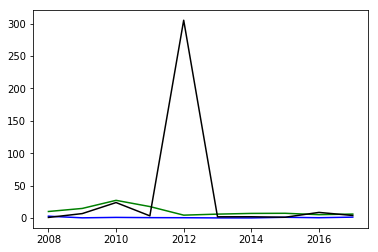

In [16]:
plt.plot(years[1:], [reso[y]['b'][3] for y in years[1:] ],color='b')
plt.plot(years[1:], [reso[y]['g'][3] for y in years[1:] ],color='g')
plt.plot(years[1:], [reso[y]['f'][3] for y in years[1:] ],color='k')
plt.show()

      BIAS  ENERGY_PRODUCTION_PAYMENTS  FIT  INVESTMENT_TAX_CREDIT    MW_own  \
2008   1.0                         0.0  0.0                    0.0  0.123621   
2009   1.0                         0.0  0.0                    0.0  0.137386   
2010   1.0                         0.0  1.0                    0.0  0.165270   
2011   1.0                         1.0  1.0                    0.0  0.171139   
2012   1.0                         1.0  1.0                    0.0  0.174722   
2013   1.0                         1.0  1.0                    0.0  0.195880   
2014   1.0                         1.0  1.0                    0.0  0.223299   
2015   1.0                         1.0  1.0                    0.0  0.255142   
2016   1.0                         1.0  1.0                    0.0  0.293380   
2017   1.0                         1.0  1.0                    0.0  0.293680   
2008   1.0                         0.0  0.0                    0.0  0.192766   
2009   1.0                         0.0  

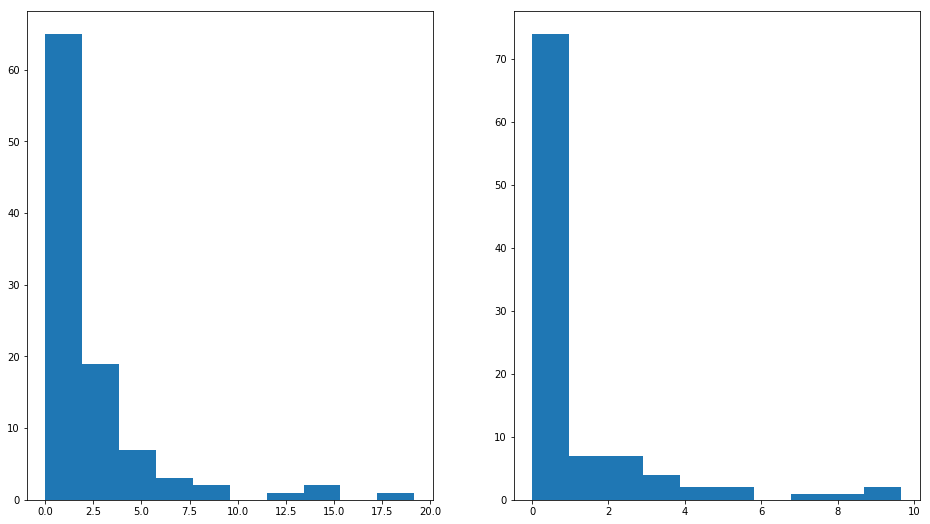

"\n\n\nfig, axs = plt.subplots(2,2,sharex=True, figsize = (16,9))\n\ncols_d = {\n    'g':'g',\n    'b':'b',\n    'f':'k'\n}\nkk = 0\nfor ii in range(2):\n    for jj in range(2):\n        for ci in ['g','b','f']:\n            d = 1\n            #axs[ii,jj].plot(years[1:], [reso[y][ci][kk] for y in years[1:] ],color=cols_d[ci])\n        kk+=1\n\n\n        \n### check\n#print est['g'][0].predict()\n\ninput_df = pd.DataFrame(input_dicts).T\n\n#print [np.array([input_dicts[y][k] for k in list(input_df)]) for y in years[1:]]\n\n        \nkk = 0\nfor ii in range(2):\n    for jj in range(2):\n        for ci in ['g','b','f']:\n            \n            predict = est[ci][kk].predict(sm.add_constant(pd.DataFrame(input_dicts).T))\n            print predict#, [est[ci][kk].predict(np.array([input_dicts[y][k] for k in list(input_df)])) for y in years[1:] ]\n            #axs[ii,jj].plot(years[1:], predict, color=cols_d[ci], ls='--')\n        \n            axs[ii,jj].plot(years[1:], [est[ci][kk].predic

In [94]:



input_dicts = {}
X = {}

for ci in ['green','blue','ff']:
    input_dicts[ci] = {}

    for y in years[1:]:
        input_vector_dict = dict(zip(list(df_policy_iso.index.values),df_policy_iso.loc[:,y].values))
        input_vector_dict['n_own'] = null_df[y][null_df[y][ci]==True][ci].sum() / float(len(null_df[y]))
        input_vector_dict['MW_own'] = null_df[y][null_df[y][str(ci)+'_MW']>10**-4][str(ci)+'_MW'].sum() / null_df[y].MW.sum()
        input_vector_dict['top_n_own'] = null_df[y][['COMPANY','MW',ci]].groupby('COMPANY').sum().sort_values('MW', ascending=False).head(20)[ci].sum() / float(len(null_df[y]))
        input_vector_dict['top_MW_own'] = null_df[y][['COMPANY','MW',str(ci)+'_MW']].groupby('COMPANY').sum().sort_values('MW', ascending=False).head(20)[str(ci)+'_MW'].sum() / null_df[y].MW.sum()
        input_vector_dict['green'] = float(ci=='green')
        input_vector_dict['blue'] = float(ci=='blue')
        input_vector_dict['ff'] = float(ci=='ff')
        input_vector_dict['BIAS']=1.0
    
        """
        input_vector_dict['n_green'] = null_df[y][null_df[y].green==True].green.sum() / float(len(null_df[y]))
        input_vector_dict['n_blue'] = null_df[y][null_df[y].blue==True].blue.sum() / float(len(null_df[y]))
        input_vector_dict['n_ff'] = null_df[y][null_df[y].ff==True].ff.sum() / float(len(null_df[y]))
        input_vector_dict['MW_green'] = null_df[y][null_df[y].green_MW>10**-4].green_MW.sum() / null_df[y].MW.sum()
        input_vector_dict['MW_blue'] = null_df[y][null_df[y].blue_MW>10**-4].blue_MW.sum() / null_df[y].MW.sum()
        input_vector_dict['MW_ff'] = null_df[y][null_df[y].ff_MW>10**-4].ff_MW.sum() / null_df[y].MW.sum()
        input_vector_dict['top_n_green'] = null_df[y][['COMPANY','MW','green','blue','ff']].groupby('COMPANY').sum().sort_values('MW', ascending=False).head(20).green.sum() / float(len(null_df[y]))
        input_vector_dict['top_n_blue'] =null_df[y][['COMPANY','MW','green','blue','ff']].groupby('COMPANY').sum().sort_values('MW', ascending=False).head(20).blue.sum() / float(len(null_df[y]))
        input_vector_dict['top_n_ff'] =null_df[y][['COMPANY','MW','green','blue','ff']].groupby('COMPANY').sum().sort_values('MW', ascending=False).head(20).green.sum() / float(len(null_df[y]))
        input_vector_dict['top_MW_green'] =null_df[y][['COMPANY','MW','green_MW','blue_MW','ff_MW']].groupby('COMPANY').sum().sort_values('MW', ascending=False).head(20).green_MW.sum() / null_df[y].MW.sum()
        input_vector_dict['top_MW_blue'] =null_df[y][['COMPANY','MW','green_MW','blue_MW','ff_MW']].groupby('COMPANY').sum().sort_values('MW', ascending=False).head(20).blue_MW.sum() / null_df[y].MW.sum()
        input_vector_dict['top_MW_ff'] =null_df[y][['COMPANY','MW','green_MW','blue_MW','ff_MW']].groupby('COMPANY').sum().sort_values('MW', ascending=False).head(20).ff_MW.sum() / null_df[y].MW.sum()
        input_vector_dict['BIAS']=1.0
        """
    
        input_dicts[ci][y] = input_vector_dict
        
    X[ci] = pd.DataFrame(input_dicts[ci]).T
    
X = pd.concat([X[ci] for ci in ['green','blue','ff']])
X = sm.add_constant(X)

print X
    #input_vector = np.array([input_vector_dict[k] for k in input_params])
    
est = {}

#for c in ['g','b','f']:
#    est[c] = {}
for ii in range(4):
    Y = [reso[y]['g'][ii] for y in years[1:]] + [reso[y]['b'][ii] for y in years[1:]] + [reso[y]['f'][ii] for y in years[1:]]
    #X = #input_vector = np.array([input_vector_dict[k] for k in input_params])
    
    #X = pd.DataFrame(input_dicts).T
        
    #X = sm.add_constant(X)

    est[ii] = sm.OLS(Y, X)
    est[ii] = est[ii].fit()

    print est[ii].summary()
        
        

fig, axs = plt.subplots(2,2,sharex=True, figsize = (16,9))

cols_d = {
    'g':'g',
    'b':'b',
    'f':'k'
}
kk = 0
for ii in range(2):
    for jj in range(2):
        for ci in ['g','b','f']:
            d = 1
            #axs[ii,jj].plot(years[1:], [reso[y][ci][kk] for y in years[1:] ],color=cols_d[ci])
        kk+=1


        
### check
#print est['g'][0].predict()

input_df = pd.DataFrame(input_dicts).T

#print [np.array([input_dicts[y][k] for k in list(input_df)]) for y in years[1:]]

        
kk = 0
for ii in range(2):
    for jj in range(2):
        for ci in ['g','b','f']:
            
            predict = est[ci][kk].predict(sm.add_constant(pd.DataFrame(input_dicts).T))
            print predict#, [est[ci][kk].predict(np.array([input_dicts[y][k] for k in list(input_df)])) for y in years[1:] ]
            #axs[ii,jj].plot(years[1:], predict, color=cols_d[ci], ls='--')
        
            axs[ii,jj].plot(years[1:], [est[ci][kk].predict(np.array([input_dicts[y][k] for k in list(input_df)])) for y in years[1:] ],color=cols_d[ci], ls='--')
        kk+=1
        
#axs[0,1].plot(years[1:], [est['f'][1].predict(np.array([input_dicts[y][k] for k in input_params])) for y in years[1:] ],color='k', ls='--')
plt.show()


In [7]:
#synth_stats = get_stats(synthetic_df)
truth_stats = get_stats(iso_slice_plants, years)
null_stats = get_stats(null_df, years)

In [9]:
#print BETA

def make_synthetic_df(iso_slice_plants, years, input_params, BETA):
    
    #pulled in - epsilons, 
    
    color_dict = {}
    color_dict['name'] = {
        'g':'green',
        'b':'blue',
        'f':'ff'
        }
    color_dict['color_arr'] = {
        'g':[1.0,0.0,0.0],
        'b':[0.0,1.0,0.0],
        'f':[0.0,0.0,1.0],
        }

    plant_ii = 0
    company_ii = 0

    synthetic_df = {}
    synthetic_df[years[0]] = iso_slice_plants[years[0]]
    synth_new_assets = {}

    for y in years[1:]:
    
        #print y
        synthetic_df[y] = copy.deepcopy(synthetic_df[y-1])
    
        #drop retired plants
        synthetic_df[y] = synthetic_df[y][~synthetic_df[y].index.isin(retired_plants[y])]
    
        input_vector_dict = dict(zip(list(df_policy_iso.index.values),df_policy_iso.loc[:,y].values))
        input_vector_dict['n_green'] = synthetic_df[y][synthetic_df[y].green==True].green.sum() / float(len(synthetic_df[y]))
        input_vector_dict['n_blue'] = synthetic_df[y][synthetic_df[y].blue==True].blue.sum() / float(len(synthetic_df[y]))
        input_vector_dict['n_ff'] = synthetic_df[y][synthetic_df[y].ff==True].ff.sum() / float(len(synthetic_df[y]))
        input_vector_dict['MW_green'] = synthetic_df[y][synthetic_df[y].green_MW>10**-4].green_MW.sum() / synthetic_df[y].MW.sum()
        input_vector_dict['MW_blue'] = synthetic_df[y][synthetic_df[y].blue_MW>10**-4].blue_MW.sum() / synthetic_df[y].MW.sum()
        input_vector_dict['MW_ff'] = synthetic_df[y][synthetic_df[y].ff_MW>10**-4].ff_MW.sum() / synthetic_df[y].MW.sum()
        input_vector_dict['top_n_green'] = synthetic_df[y][['COMPANY','MW','green','blue','ff']].groupby('COMPANY').sum().sort_values('MW', ascending=False).head(20).green.sum() / float(len(synthetic_df[y]))
        input_vector_dict['top_n_blue'] =synthetic_df[y][['COMPANY','MW','green','blue','ff']].groupby('COMPANY').sum().sort_values('MW', ascending=False).head(20).blue.sum() / float(len(synthetic_df[y]))
        input_vector_dict['top_n_ff'] =synthetic_df[y][['COMPANY','MW','green','blue','ff']].groupby('COMPANY').sum().sort_values('MW', ascending=False).head(20).green.sum() / float(len(synthetic_df[y]))
        input_vector_dict['top_MW_green'] =synthetic_df[y][['COMPANY','MW','green_MW','blue_MW','ff_MW']].groupby('COMPANY').sum().sort_values('MW', ascending=False).head(20).green_MW.sum() / synthetic_df[y].MW.sum()
        input_vector_dict['top_MW_blue'] =synthetic_df[y][['COMPANY','MW','green_MW','blue_MW','ff_MW']].groupby('COMPANY').sum().sort_values('MW', ascending=False).head(20).blue_MW.sum() / synthetic_df[y].MW.sum()
        input_vector_dict['top_MW_ff'] =synthetic_df[y][['COMPANY','MW','green_MW','blue_MW','ff_MW']].groupby('COMPANY').sum().sort_values('MW', ascending=False).head(20).ff_MW.sum() / synthetic_df[y].MW.sum()
        input_vector_dict['BIAS']=1.0
    
        #print 'meow'
    
        #print input_vector_dict
    
        input_vector = np.array([input_vector_dict[k] for k in input_params])
    
        for c in ['g','b','f']:
            #print np.dot(input_vector,BETA[c]['weib_a']), np.dot(input_vector,BETA[c]['weib_c'])
            weib_params[c] = np.exp(np.dot(input_vector,BETA[c]['weib']))

            Pr[c] = np.exp(np.dot(input_vector, BETA[c]['pr']))
            print c, 'prob', Pr[c], 'weib', weib_params[c]
        

        synth_new_assets[y] = []

    
        ADD_MW = iso_slice_plants[y].ix[new_plants[y]].MW.sum()
    
        NEW_MW=0.0
    
        while NEW_MW<=ADD_MW:
        
            ### GENERATE A NEW ASSET
            c = np.random.choice(['g','b','f'],p=np.array([Pr[c] for c in ['g','b','f']])/np.sum([Pr[c] for c in ['g','b','f']]))
            MW = s.exponweib.rvs(*weib_params[c], size=1)[0]
            synth_new_assets[y].append({'color':c,'MW':MW})
            NEW_MW+=MW
            
        print 'n new assets', len(synth_new_assets[y])
        
        
        ### PREFERENTIALLY ATTACH IT (AS IN NULL MODEL FOR NOW)
        x = synthetic_df[y-1][['MW','COMPANY','green','blue','ff']]
    
        #x['_size'] = (np.log10(x['MW'])-np.log10(null_df[y-1]['MW'].min()))/float(np.log10(null_df[y-1]['MW'].max())-np.log10(null_df[y-1]['MW'].min()))
        x['_size'] = (x['MW']-synthetic_df[y-1]['MW'].min())/float(synthetic_df[y-1]['MW'].max()-synthetic_df[y-1]['MW'].min())
        #x['_size'] = x['MW'].sort_values().cumsum()/x.MW.sum()
        x['_green'] = x['green'].astype(int)
        x['_blue'] = x['blue'].astype(int)
        x['_ff'] = x['ff'].astype(int)
        x['_norm'] = np.sqrt(np.square(x[['_size','_green','_blue','_ff']]).sum(axis=1))
    
        n = pd.DataFrame(synth_new_assets[y])
        #n['_size'] = (np.log10(n['MW'])-np.log10(null_df[y-1]['MW'].min()))/float(np.log10(null_df[y-1]['MW'].max())-np.log10(null_df[y-1]['MW'].min()))
        n['_size'] = (n['MW']-synthetic_df[y-1]['MW'].min())/float(synthetic_df[y-1]['MW'].max()-synthetic_df[y-1]['MW'].min())
        n['_green'] = (n['color']=='g').astype(int)
        n['_blue'] = (n['color']=='b').astype(int)  
        n['_ff'] = (n['color']=='f').astype(int) 
        n['_norm'] = np.sqrt(np.square(n[['_size','_green','_blue','_ff']]).sum(axis=1))
    
        for c in ['_size','_green','_blue','_ff']:
            x[c] = x[c]/x['_norm']
            n[c] = n[c]/n['_norm']
        
        
        X = x[['_size','_green','_blue','_ff']].values
        N = n[['_size','_green','_blue','_ff']].values
    
    
        ### Difference method
        X = np.stack([X for _ in range(N.shape[0])], axis=0)
        N =np.stack([N for _ in range(X.shape[1])], axis=1)
    
        P = 1.0/(((X-N)**2).sum(axis=-1))
        P = P/P.sum(axis=-1)[:, np.newaxis]
  
        select = random_choice_prob_index(P, axis=1)
    
        for ii, n_a in enumerate(synth_new_assets[y]):
            if np.random.rand()<epsilons[y][color_dict['name'][n_a['color']]+'_MW']:
            
                name = 'NEW_COMPANY_'+str(company_ii)
                company_ii+=1
                #print 'new company'
            else:
                #print 'n_MW: ', n_a['MW'], 'chosen_MW: ',x.iloc[select[ii]].MW, 'color:', n_a['color'], 'ch_col:', x.iloc[select[ii]].green, x.iloc[select[ii]].blue,x.iloc[select[ii]].ff
                name = x.iloc[select[ii]].COMPANY
            
        
            synthetic_df[y] = synthetic_df[y].append(pd.DataFrame({
                'COMPANY':name, 
                'fuel_class':'N/A_GEN', 
                'YEAR':y, 
                'green':color_dict['color_arr'][n_a['color']][0], 
                'blue':color_dict['color_arr'][n_a['color']][1], 
                'solar':0.0, 
                'wind':0.0, 
                'ff':color_dict['color_arr'][n_a['color']][2], 
                'MW':n_a['MW'], 
                'CCCE':0.0, 
                'green_MW':color_dict['color_arr'][n_a['color']][0]*n_a['MW'], 
                'blue_MW':color_dict['color_arr'][n_a['color']][1]*n_a['MW'], 
                'solar_MW':0.0, 
                'wind_MW':0.0, 
                'ff_MW':color_dict['color_arr'][n_a['color']][2]*n_a['MW'],
            }, index=['NEW_PLANT_'+str(plant_ii)]))
        
            plant_ii+=1
    
        for p in extra_plants[y]:
            synthetic_df[y] = synthetic_df[y].append(iso_slice_plants[y].ix[p])
    return synthetic_df

In [10]:
### MAKE SOME MORE SYNTHETIC DFS

GENOMES = []
fitnesses = []

BETA = {}

for c in ['g','b','f']:
    BETA[c] = {}
    BETA[c]['weib'] = np.zeros((len(input_params),4))
    BETA[c]['pr'] = np.zeros((len(input_params)))
    #BETA[c]['weib'][0,-1] = np.log(0.001)
    #BETA[c]['weib'][1,-1] = np.log(0.5)
    #BETA[c]['weib'][2,-1] = np.log(0.001)
    #BETA[c]['weib'][3,-1] = np.log(10.0)
    BETA[c]['weib'][-1,:] = np.log(np.array([1.0,0.5,0.0001,2.0]))
    BETA[c]['pr'][-1] = np.log(0.33)
        
GENOMES.append(copy.deepcopy(BETA))

synthetic_df = make_synthetic_df(iso_slice_plants, years, input_params, BETA)
synth_stats = get_stats(synthetic_df, years)

print get_fitness(truth_stats, synth_stats)

"""

for _ in range(9):
    BETA = {}

    for c in ['g','b','f']:
        BETA[c] = {}
        for p in ['weib_a','weib_c','pr']:
            BETA[c][p] = np.zeros((len(input_params)))
        
        BETA[c]['weib_a'][-1] = np.log(0.5)
        BETA[c]['weib_c'][-1] = np.log(10.0)
        BETA[c]['pr'][-1] = np.log(0.33)
        
    GENOMES.append(copy.deepcopy(BETA))
    
    
for it in range(1):
    fitenesses = []
    ### mutate some genomes
    for ii in range(len(GENOMES)):
        for c in ['g','b','f']:
            for p in ['weib_a','weib_c','pr']:
                for jj in range(len(input_params)):
                    if np.random.rand()<0.1:
                        GENOMES[ii][c][p][jj]+= (np.random.rand()-0.5)/5.0
                    
    #print GENOMES
    
    ### get their fitnesses
    for ii in range(len(GENOMES)):
        print 'it: ', it, 'ii: ', ii        
        synthetic_df = make_synthetic_df(iso_slice_plants, years, input_params, GENOMES[ii])
        synth_stats = get_stats(synthetic_df, years)
        fitnesses.append(get_fitness(truth_stats,synth_stats))
        
    print fitnesses
    
"""

[u'FIT', u'RPS', u'INVESTMENT_TAX_CREDIT', u'SALES_TAX_CREDIT', u'TRADEABLE_RECS', u'ENERGY_PRODUCTION_PAYMENTS', u'NET_METERING', u'PUBLIC_INVESTMENT', u'TENDERING', 'YEAR', 'n_green', 'n_blue', 'n_ff', 'MW_green', 'MW_blue', 'MW_ff', 'top_n_green', 'top_n_blue', 'top_n_ff', 'top_MW_green', 'top_MW_blue', 'top_MW_ff', 'BIAS']


NameError: global name 'retired_plants' is not defined

In [11]:
synthetic_df = make_synthetic_df(iso_slice_plants, years, input_params, BETA)
synth_stats = get_stats(synthetic_df, years)

g prob 0.33 weib [  1.00000000e+00   5.00000000e-01   1.00000000e-04   2.00000000e+00]
b prob 0.33 weib [  1.00000000e+00   5.00000000e-01   1.00000000e-04   2.00000000e+00]
f prob 0.33 weib [  1.00000000e+00   5.00000000e-01   1.00000000e-04   2.00000000e+00]
n new assets 251
g prob 0.33 weib [  1.00000000e+00   5.00000000e-01   1.00000000e-04   2.00000000e+00]
b prob 0.33 weib [  1.00000000e+00   5.00000000e-01   1.00000000e-04   2.00000000e+00]
f prob 0.33 weib [  1.00000000e+00   5.00000000e-01   1.00000000e-04   2.00000000e+00]
n new assets 352
g prob 0.33 weib [  1.00000000e+00   5.00000000e-01   1.00000000e-04   2.00000000e+00]
b prob 0.33 weib [  1.00000000e+00   5.00000000e-01   1.00000000e-04   2.00000000e+00]
f prob 0.33 weib [  1.00000000e+00   5.00000000e-01   1.00000000e-04   2.00000000e+00]
n new assets 950
g prob 0.33 weib [  1.00000000e+00   5.00000000e-01   1.00000000e-04   2.00000000e+00]
b prob 0.33 weib [  1.00000000e+00   5.00000000e-01   1.00000000e-04   2.000000

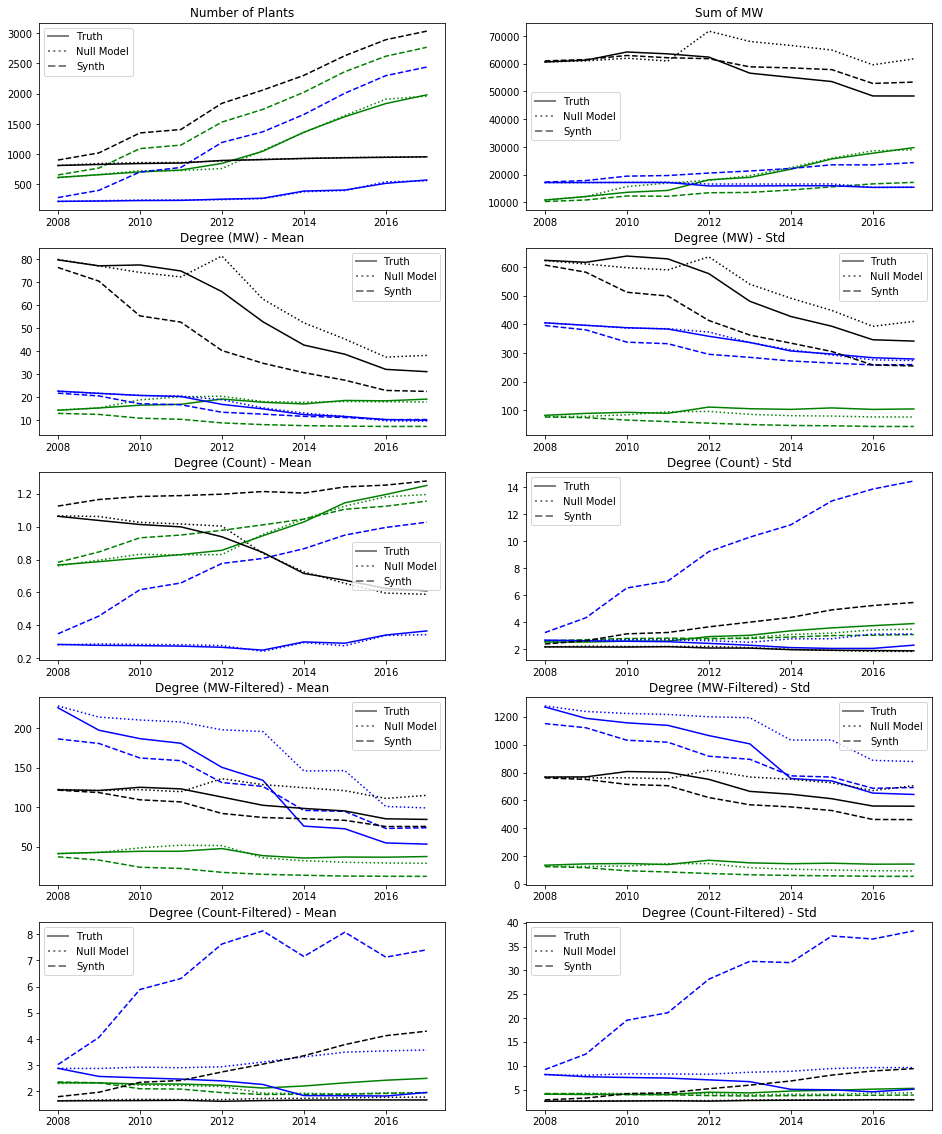

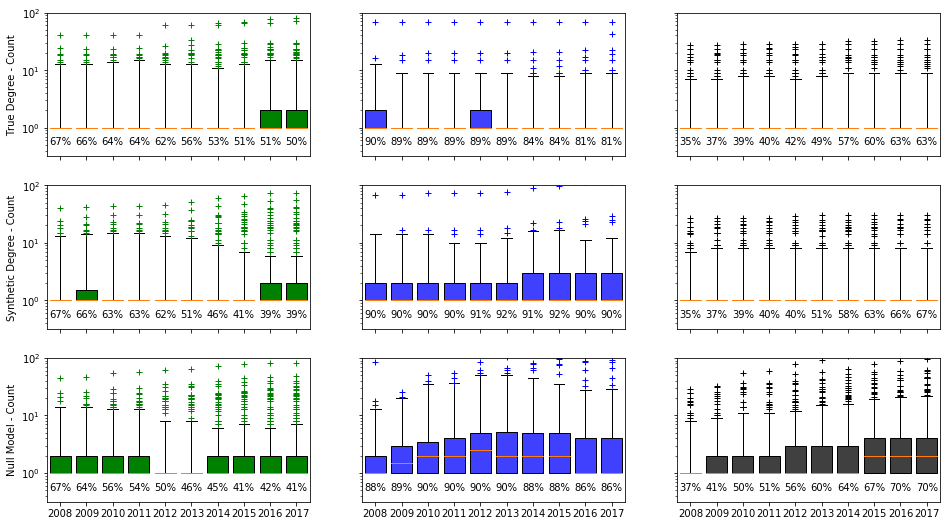

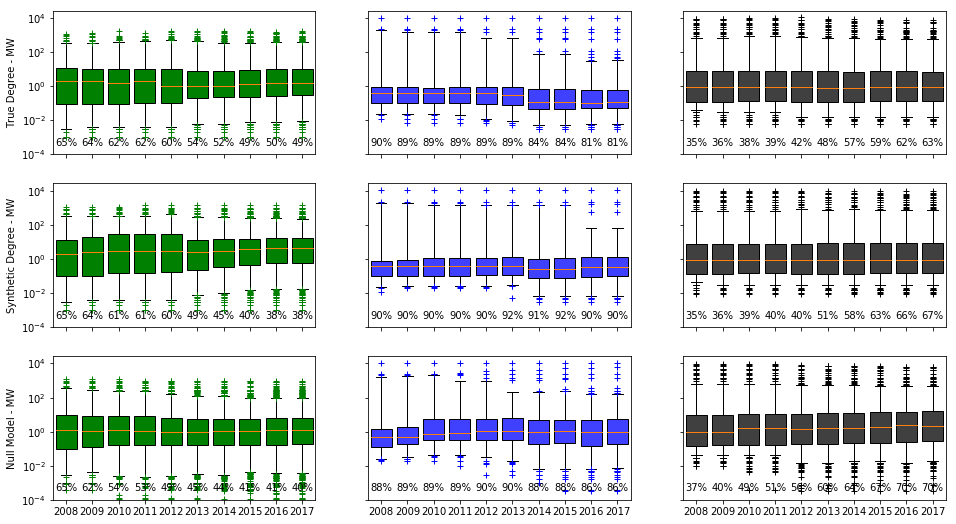

0

In [12]:
plot_stats(truth_stats, synth_stats, null_stats, years)
plot_DD(iso_slice_plants, synthetic_df, null_df, years, MW=False)
plot_DD(iso_slice_plants, synthetic_df, null_df, years, MW=True)

In [ ]:
plot_ternary(iso_slice_plants, synthetic_df, null_df)